# *Import*

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import cv2
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from keras import layers
import seaborn as sn
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras import datasets, layers, models
from keras.regularizers import l2
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D,BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout,GlobalAveragePooling2D,concatenate
from keras.initializers import random_uniform, glorot_uniform
from keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import cross_val_score, KFold

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1PF4Su7qw_bQOLSbVYeZdp7nDSBLq1i0s/view?usp=sharing'
id = '1PF4Su7qw_bQOLSbVYeZdp7nDSBLq1i0s'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('weather.zip')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -u "weather.zip" -d"/content/drive/My Drive/DLprojects/exe"

Archive:  weather.zip


# *Preprocessing*

## Categorizing

In [ ]:
pics = []
labels = []
max_height = -1
max_width = -1
#convert = {'Sunrise':0,'Cloudy':1,'Shine':2,'Rain':3}
path = '/content/drive/My Drive/DLprojects/exe/Multi-class Weather Dataset'
print(os.listdir(path))
for i in os.listdir(path):
  for j in os.listdir(path+'/'+i):
    pic = cv2.imread(path+'/'+i+'/'+j)
    if pic is not None:
      pics.append(pic)
      if i == "Cloudy":
        labels.append(0)
      if i == "Rain":
        labels.append(1)
      if i == "Shine":
          labels.append(2)
      if i == "Sunrise":
        labels.append(3)
      max_height = max(max_height, pic.shape[0])
      max_width = max(max_width, pic.shape[1])


['Cloudy', 'Rain', 'Shine', 'Sunrise']


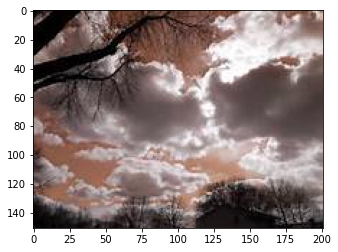

(151, 201, 3)
<class 'list'>
<class 'numpy.ndarray'>


In [ ]:
pic = pics[10]
pyplot.imshow(pic,cmap=pyplot.get_cmap('gray'))
pyplot.show()
print(pic.shape)
print(type(pics))
print(type(pic))

## Resize all pics

In [ ]:
for i in range(len(pics)):
  pics[i] = resize(pics[i],(200, 200)) #resizing pictures to 200*200

## Labeling data

In [ ]:
label = np.zeros((len(labels), 4))
for i in range(len(labels)):
  label[i][labels[i]] = 1

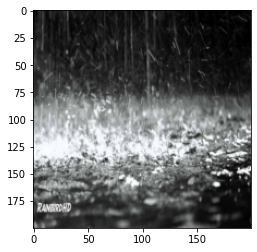

array([0., 1., 0., 0.])

In [ ]:
pyplot.imshow(pics[500],cmap=pyplot.get_cmap('gray'))
pyplot.show()
label[500]

## Report function

In [ ]:
def report(history, model, X_train, X_test, y_train, y_test, epoch = 50):
  #plotting train and validation loss
  loss_train = history.history['loss']
  loss_val = history.history['val_loss']
  epochs = range(0,epoch)
  plt.plot(epochs,loss_train,'g',label='Training loss')
  plt.plot(epochs,loss_val,'b',label='Validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  print()
  #plotting train and validation accuracy
  acc_train = history.history['accuracy']
  acc_val = history.history['val_accuracy']
  epochs = range(0,epoch)
  plt.plot(epochs,acc_train,'r',label='Training accuracy')
  plt.plot(epochs,acc_val,'y',label='Validation accuarcy')
  plt.title('Training and Validation accuarcy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuarcy')
  plt.legend()
  plt.show()
  print()
  #printing report for train and validation
  print("Train report")
  y_pred = model.predict(X_train)
  y_pred_label=np.argmax(y_pred,axis=1)
  y_train_clf = np.argmax(y_train,axis=1)
  print(classification_report(y_train_clf, y_pred_label))
  print()
  print()
  print("test report")
  y_pred = model.predict(X_test)
  y_pred_label=np.argmax(y_pred,axis=1)
  y_train_clf = np.argmax(y_test,axis=1)
  print(classification_report(y_train_clf, y_pred_label))

## Confusion matrix

In [ ]:
#confusion matrix function
def Confusion(model, X_train, X_test, y_train, y_test):
  print("Train report")
  y_pred = model.predict(X_train)
  y_pred_label=np.argmax(y_pred,axis=1)
  y_train_clf = np.argmax(y_train,axis=1)
  print(classification_report(y_train_clf, y_pred_label))
  print()
  print()
  print("test report")
  y_pred = model.predict(X_test)
  y_pred_label=np.argmax(y_pred,axis=1)
  y_train_clf = np.argmax(y_test,axis=1)
  print(classification_report(y_train_clf, y_pred_label))
  print()

## Report function (Inception)

In [ ]:
#report function for inception model
def report_inc(history, model, X_train, X_test, y_train, y_test):
  #plotting train and validation loss for inception model
  loss_train = history.history['output_loss']
  loss_val = history.history['val_output_loss']
  epochs = range(0,50)
  plt.plot(epochs,loss_train,'g',label='Training loss')
  plt.plot(epochs,loss_val,'b',label='Validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  print()
  #plotting train and validation accuracy for inception model
  acc_train = history.history['output_accuracy']
  acc_val = history.history['val_output_accuracy']
  epochs = range(0,50)
  plt.plot(epochs,acc_train,'r',label='Training accuracy')
  plt.plot(epochs,acc_val,'y',label='Validation accuarcy')
  plt.title('Training and Validation accuarcy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuarcy')
  plt.legend()
  plt.show()
  print()
  #train and validation report for train and validation for inception model
  print("Train report")
  y_pred = model.predict(X_train)
  y_pred_label=np.argmax(y_pred[2],axis=1)
  y_train_clf = np.argmax(y_train,axis=1)
  print(classification_report(y_train_clf, y_pred_label))
  print()
  print()
  print("test report")
  y_pred = model.predict(X_test)
  y_pred_label=np.argmax(y_pred[2],axis=1)
  y_train_clf = np.argmax(y_test,axis=1)
  print(classification_report(y_train_clf, y_pred_label))

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,

    validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    path,
    target_size=(200 , 200),
    batch_size = 1,
    class_mode='categorical',
    subset='training')
valid_generator = train_datagen.flow_from_directory(
    path,
    batch_size = 1,
    target_size=(200, 200),
    class_mode='categorical',
    subset='validation')

Found 901 images belonging to 4 classes.
Found 224 images belonging to 4 classes.


In [ ]:
type(train_generator)

keras.preprocessing.image.DirectoryIterator

In [ ]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 30
)

x_t, y_t = next(generator.flow_from_directory(path, batch_size=1))

Found 1125 images belonging to 4 classes.


In [ ]:
print(os.listdir(path))

['Cloudy', 'Rain', 'Shine', 'Sunrise']


In [ ]:
print(len(pics))

1123


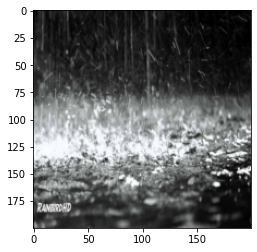

(200, 200, 3)


array([0., 1., 0., 0.])

In [ ]:
pic = pics[500]
pyplot.imshow(pic,cmap=pyplot.get_cmap('gray'))
pyplot.show()
print(pic.shape)
label[500]

## Split data to train and test

In [ ]:
#spliting data to train and val (80%->train, 20%->val)
X_train, X_test, y_train, y_test = train_test_split(pics, label, test_size=0.2, random_state=42)
X_train=np.array(X_train)
X_test=np.array(X_test)
X_train=X_train/255.0
X_test=X_test/255.0
print(X_train.shape)

(898, 200, 200, 3)


## Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(200, 200),
  layers.Rescaling(1./255)
])

# *Fully connected version*

## 3 Hidden layers

In [ ]:
m1 = models.Sequential([
        layers.Flatten(input_shape=(200,200,3)),
        layers.Dense(50, activation='relu'),
        layers.Dense(30, activation='relu'),
        layers.Dense(10, activation='relu'),
        layers.Dense(4, activation='softmax') #using softmax as activation function for the output layer
    ])
opt = keras.optimizers.Adam(learning_rate=0.001) #using adam optimizer with 0.001 learning rate
m1.compile(optimizer = opt, loss= tf.keras.losses.CategoricalCrossentropy() ,metrics=['accuracy'])
#printing summary of the model
m1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 120000)            0         
                                                                 
 dense_8 (Dense)             (None, 50)                6000050   
                                                                 
 dense_9 (Dense)             (None, 30)                1530      
                                                                 
 dense_10 (Dense)            (None, 10)                310       
                                                                 
 dense_11 (Dense)            (None, 4)                 44        
                                                                 
Total params: 6,001,934
Trainable params: 6,001,934
Non-trainable params: 0
_________________________________________________________________


### Compile

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'): #using gpu
  history = m1.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=50)

Epoch 1/50
29/29 [==============================] - 2s 27ms/step - loss: 1.1515 - accuracy: 0.5479 - val_loss: 0.9765 - val_accuracy: 0.5333
Epoch 2/50
29/29 [==============================] - 0s 13ms/step - loss: 0.8176 - accuracy: 0.6949 - val_loss: 0.7790 - val_accuracy: 0.7289
Epoch 3/50
29/29 [==============================] - 0s 16ms/step - loss: 0.6904 - accuracy: 0.7572 - val_loss: 0.7213 - val_accuracy: 0.7556
Epoch 4/50
29/29 [==============================] - 0s 13ms/step - loss: 0.6234 - accuracy: 0.7673 - val_loss: 0.6391 - val_accuracy: 0.7822
Epoch 5/50
29/29 [==============================] - 0s 13ms/step - loss: 0.5725 - accuracy: 0.7906 - val_loss: 0.6146 - val_accuracy: 0.8089
Epoch 6/50
29/29 [==============================] - 0s 14ms/step - loss: 0.5389 - accuracy: 0.8040 - val_loss: 0.6172 - val_accuracy: 0.8000
Epoch 7/50
29/29 [==============================] - 0s 13ms/step - loss: 0.5270 - accuracy: 0.7906 - val_loss: 0.6057 - val_accuracy: 0.8000
Epoch 8/50
29

### Report

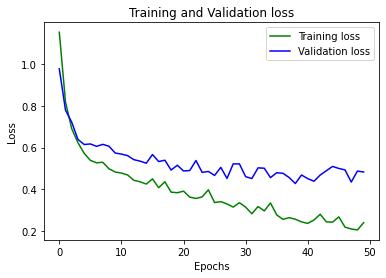

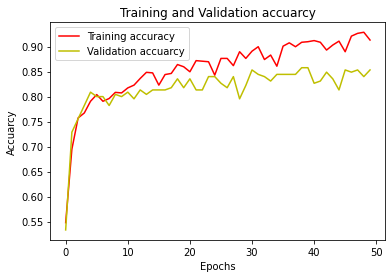


Train report
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       239
           1       0.80      0.94      0.87       170
           2       0.96      0.95      0.95       199
           3       1.00      0.99      0.99       290

    accuracy                           0.93       898
   macro avg       0.92      0.92      0.92       898
weighted avg       0.93      0.93      0.93       898



test report
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        61
           1       0.83      0.89      0.86        44
           2       0.80      0.81      0.80        53
           3       0.98      0.93      0.95        67

    accuracy                           0.85       225
   macro avg       0.85      0.85      0.85       225
weighted avg       0.86      0.85      0.85       225



In [ ]:
report(history, m1, X_train, X_test, y_train, y_test)

## 5 Hidden layers

In [ ]:
m1 = models.Sequential([
        layers.Flatten(input_shape=(200,200,3)),
        layers.Dense(50, activation='relu'),
        layers.Dense(30, activation='relu'),
        layers.Dense(40, activation='relu'),
        layers.Dense(30, activation='relu'),
        layers.Dense(30, activation='relu'),
        layers.Dense(4, activation='softmax')   #using softmax as activation function for the output layer
    ])
opt = keras.optimizers.Adam(learning_rate=0.001)
m1.compile(optimizer = opt, loss= tf.keras.losses.CategoricalCrossentropy() ,metrics=['accuracy'])
m1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 120000)            0         
                                                                 
 dense_12 (Dense)            (None, 50)                6000050   
                                                                 
 dense_13 (Dense)            (None, 30)                1530      
                                                                 
 dense_14 (Dense)            (None, 40)                1240      
                                                                 
 dense_15 (Dense)            (None, 30)                1230      
                                                                 
 dense_16 (Dense)            (None, 30)                930       
                                                                 
 dense_17 (Dense)            (None, 4)                

### Compile

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'):
  history = m1.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=50)

Epoch 1/50
29/29 [==============================] - 1s 22ms/step - loss: 1.2495 - accuracy: 0.4666 - val_loss: 1.0358 - val_accuracy: 0.5156
Epoch 2/50
29/29 [==============================] - 0s 13ms/step - loss: 0.8754 - accuracy: 0.6203 - val_loss: 0.7930 - val_accuracy: 0.7022
Epoch 3/50
29/29 [==============================] - 0s 14ms/step - loss: 0.7016 - accuracy: 0.7149 - val_loss: 0.8319 - val_accuracy: 0.6756
Epoch 4/50
29/29 [==============================] - 0s 13ms/step - loss: 0.6920 - accuracy: 0.7127 - val_loss: 0.7088 - val_accuracy: 0.7644
Epoch 5/50
29/29 [==============================] - 0s 13ms/step - loss: 0.6003 - accuracy: 0.7628 - val_loss: 0.7156 - val_accuracy: 0.7156
Epoch 6/50
29/29 [==============================] - 0s 13ms/step - loss: 0.6117 - accuracy: 0.7550 - val_loss: 0.6529 - val_accuracy: 0.7200
Epoch 7/50
29/29 [==============================] - 0s 16ms/step - loss: 0.5507 - accuracy: 0.7929 - val_loss: 0.5970 - val_accuracy: 0.7778
Epoch 8/50
29

### Report

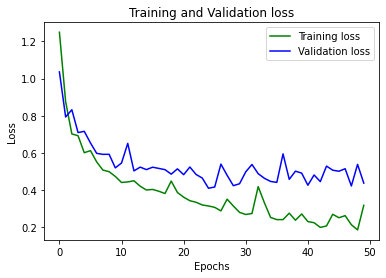

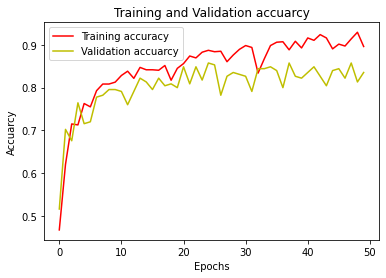


Train report
              precision    recall  f1-score   support

           0       0.85      0.92      0.89       239
           1       0.94      0.78      0.85       170
           2       0.95      0.99      0.97       199
           3       1.00      1.00      1.00       290

    accuracy                           0.93       898
   macro avg       0.93      0.92      0.93       898
weighted avg       0.94      0.93      0.93       898



test report
              precision    recall  f1-score   support

           0       0.73      0.84      0.78        61
           1       0.88      0.64      0.74        44
           2       0.80      0.91      0.85        53
           3       0.97      0.91      0.94        67

    accuracy                           0.84       225
   macro avg       0.84      0.82      0.83       225
weighted avg       0.85      0.84      0.83       225



In [ ]:
report(history, m1, X_train, X_test, y_train, y_test)

## 7 Hidden layers

In [ ]:
model = models.Sequential([
        layers.Flatten(input_shape=(200,200,3)),
        layers.Dense(50, activation='tanh', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        BatchNormalization(),
        layers.Dense(30, activation='tanh', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        BatchNormalization(),
        layers.Dense(40, activation='tanh', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        BatchNormalization(),
        layers.Dense(30, activation='tanh', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        BatchNormalization(),
        layers.Dense(30, activation='tanh', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        layers.Dense(4, activation='softmax')    #using softmax as activation function for the output layer
    ])
opt = keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer = opt, loss= tf.keras.losses.CategoricalCrossentropy() ,metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 120000)            0         
                                                                 
 dense_18 (Dense)            (None, 50)                6000050   
                                                                 
 batch_normalization (BatchN  (None, 50)               200       
 ormalization)                                                   
                                                                 
 dense_19 (Dense)            (None, 30)                1530      
                                                                 
 batch_normalization_1 (Batc  (None, 30)               120       
 hNormalization)                                                 
                                                                 
 dense_20 (Dense)            (None, 40)               

### Compile

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'):
  history = m1.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=50)

Epoch 1/50
29/29 [==============================] - 1s 17ms/step - loss: 0.2106 - accuracy: 0.9209 - val_loss: 0.4858 - val_accuracy: 0.8222
Epoch 2/50
29/29 [==============================] - 0s 14ms/step - loss: 0.1970 - accuracy: 0.9209 - val_loss: 0.4780 - val_accuracy: 0.8622
Epoch 3/50
29/29 [==============================] - 0s 13ms/step - loss: 0.1661 - accuracy: 0.9454 - val_loss: 0.5350 - val_accuracy: 0.8533
Epoch 4/50
29/29 [==============================] - 0s 14ms/step - loss: 0.1745 - accuracy: 0.9321 - val_loss: 0.6726 - val_accuracy: 0.8089
Epoch 5/50
29/29 [==============================] - 0s 14ms/step - loss: 0.1622 - accuracy: 0.9410 - val_loss: 0.5024 - val_accuracy: 0.8444
Epoch 6/50
29/29 [==============================] - 0s 13ms/step - loss: 0.1477 - accuracy: 0.9454 - val_loss: 0.4491 - val_accuracy: 0.8667
Epoch 7/50
29/29 [==============================] - 0s 14ms/step - loss: 0.1399 - accuracy: 0.9543 - val_loss: 0.5750 - val_accuracy: 0.8044
Epoch 8/50
29

### Report

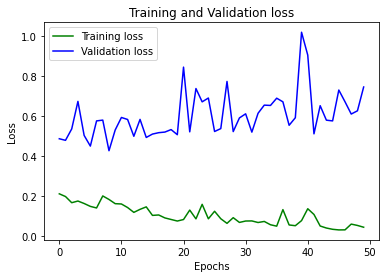

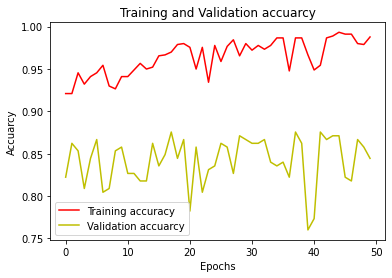


Train report
              precision    recall  f1-score   support

           0       0.98      0.81      0.89       239
           1       0.79      1.00      0.88       170
           2       1.00      0.98      0.99       199
           3       1.00      1.00      1.00       290

    accuracy                           0.95       898
   macro avg       0.94      0.95      0.94       898
weighted avg       0.96      0.95      0.95       898



test report
              precision    recall  f1-score   support

           0       0.84      0.75      0.79        61
           1       0.72      0.89      0.80        44
           2       0.86      0.79      0.82        53
           3       0.94      0.94      0.94        67

    accuracy                           0.84       225
   macro avg       0.84      0.84      0.84       225
weighted avg       0.85      0.84      0.84       225



In [ ]:
report(history, m1, X_train, X_test, y_train, y_test)

# *Fully connected (Drop out)*

## First model

In [ ]:
model = models.Sequential([
        layers.Flatten(input_shape=(200,200,3)),
        layers.Dense(100, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        Dropout(0.4),
        layers.Dense(80, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        Dropout(0.4),
        layers.Dense(80, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        Dropout(0.6),
        layers.Dense(60, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        Dropout(0.6),
        layers.Dense(60, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        Dropout(0.7),
        layers.Dense(50, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        Dropout(0.7),
        layers.Dense(50, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        Dropout(0.7),
        layers.Dense(30, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        Dropout(0.7),
        layers.Dense(30, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        layers.Dense(4, activation='softmax')  #using softmax as activation function for the output layer
    ])
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss= tf.keras.losses.CategoricalCrossentropy() ,metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 120000)            0         
                                                                 
 dense_24 (Dense)            (None, 100)               12000100  
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_25 (Dense)            (None, 80)                8080      
                                                                 
 dropout_1 (Dropout)         (None, 80)                0         
                                                                 
 dense_26 (Dense)            (None, 80)                6480      
                                                                 
 dropout_2 (Dropout)         (None, 80)               

### Compile

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'):
  history = m1.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=50)

Epoch 1/50
29/29 [==============================] - 1s 21ms/step - loss: 0.0590 - accuracy: 0.9744 - val_loss: 0.6458 - val_accuracy: 0.8578
Epoch 2/50
29/29 [==============================] - 0s 13ms/step - loss: 0.0441 - accuracy: 0.9855 - val_loss: 0.7059 - val_accuracy: 0.8489
Epoch 3/50
29/29 [==============================] - 0s 14ms/step - loss: 0.1316 - accuracy: 0.9532 - val_loss: 0.9323 - val_accuracy: 0.8133
Epoch 4/50
29/29 [==============================] - 0s 14ms/step - loss: 0.1373 - accuracy: 0.9410 - val_loss: 0.6800 - val_accuracy: 0.8267
Epoch 5/50
29/29 [==============================] - 0s 13ms/step - loss: 0.0513 - accuracy: 0.9800 - val_loss: 0.6465 - val_accuracy: 0.8533
Epoch 6/50
29/29 [==============================] - 0s 14ms/step - loss: 0.0687 - accuracy: 0.9788 - val_loss: 0.5894 - val_accuracy: 0.8578
Epoch 7/50
29/29 [==============================] - 0s 13ms/step - loss: 0.0443 - accuracy: 0.9889 - val_loss: 0.6160 - val_accuracy: 0.8622
Epoch 8/50
29

### Report

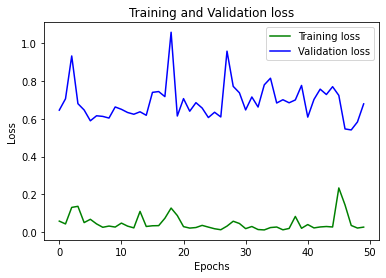

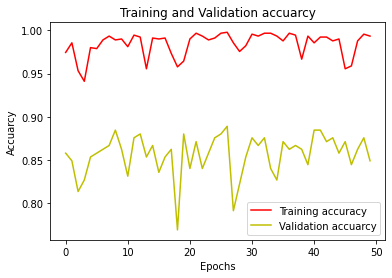


Train report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       239
           1       1.00      0.98      0.99       170
           2       0.99      1.00      1.00       199
           3       1.00      1.00      1.00       290

    accuracy                           0.99       898
   macro avg       0.99      0.99      0.99       898
weighted avg       0.99      0.99      0.99       898



test report
              precision    recall  f1-score   support

           0       0.74      0.85      0.79        61
           1       0.96      0.61      0.75        44
           2       0.79      0.91      0.84        53
           3       0.97      0.96      0.96        67

    accuracy                           0.85       225
   macro avg       0.87      0.83      0.84       225
weighted avg       0.86      0.85      0.85       225



In [ ]:
report(history, m1, X_train, X_test, y_train, y_test)

# *CNN*

## First model

In [ ]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=11, kernel_size=(11,11),
                           strides=(4,4), activation='relu',
                           input_shape=(200,200,3)),
    Dropout(0.6),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(5,5),
                           strides=(2,2), activation='relu',
                           padding="same"),
    Dropout(0.6),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(3,3),
                           strides=(1,1), activation='relu',
                           padding="same"),
    Dropout(0.6),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(200,activation='relu'),
    tf.keras.layers.Dense(4,activation='softmax')  #using softmax as activation function for the output layer
])
opt = keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer = opt, loss= tf.keras.losses.CategoricalCrossentropy() ,metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 11)        4004      
                                                                 
 dropout (Dropout)           (None, 48, 48, 11)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 11)        3036      
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 11)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 11)        1100      
                                                                 
 dropout_2 (Dropout)         (None, 24, 24, 11)        0         
                                                                 
 flatten (Flatten)           (None, 6336)             

### Compile

In [ ]:

history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=50)

Epoch 1/50
29/29 [==============================] - 16s 485ms/step - loss: 1.3033 - accuracy: 0.3753 - val_loss: 1.1487 - val_accuracy: 0.4800
Epoch 2/50
29/29 [==============================] - 10s 326ms/step - loss: 0.9825 - accuracy: 0.5735 - val_loss: 0.8519 - val_accuracy: 0.6356
Epoch 3/50
29/29 [==============================] - 8s 293ms/step - loss: 0.8897 - accuracy: 0.6192 - val_loss: 1.7646 - val_accuracy: 0.3600
Epoch 4/50
29/29 [==============================] - 9s 294ms/step - loss: 0.8562 - accuracy: 0.6537 - val_loss: 2.3802 - val_accuracy: 0.2844
Epoch 5/50
29/29 [==============================] - 9s 294ms/step - loss: 0.8051 - accuracy: 0.6982 - val_loss: 1.5663 - val_accuracy: 0.3867
Epoch 6/50
29/29 [==============================] - 9s 294ms/step - loss: 0.7555 - accuracy: 0.7082 - val_loss: 0.9708 - val_accuracy: 0.5778
Epoch 7/50
29/29 [==============================] - 9s 294ms/step - loss: 0.7112 - accuracy: 0.7261 - val_loss: 0.7233 - val_accuracy: 0.7022
Epoc

### Report

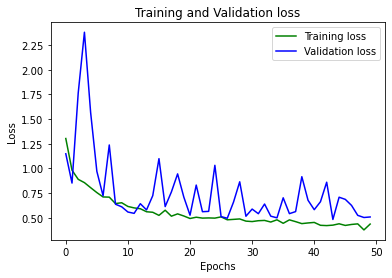

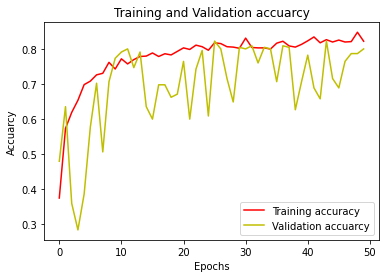


Train report
              precision    recall  f1-score   support

           0       0.70      0.86      0.77       239
           1       0.83      0.56      0.67       170
           2       0.90      0.91      0.90       199
           3       0.99      0.98      0.98       290

    accuracy                           0.85       898
   macro avg       0.85      0.83      0.83       898
weighted avg       0.86      0.85      0.85       898



test report
              precision    recall  f1-score   support

           0       0.64      0.79      0.71        61
           1       0.90      0.61      0.73        44
           2       0.76      0.79      0.78        53
           3       0.97      0.94      0.95        67

    accuracy                           0.80       225
   macro avg       0.82      0.78      0.79       225
weighted avg       0.82      0.80      0.80       225



In [ ]:
report(history, model, X_train, X_test, y_train, y_test)

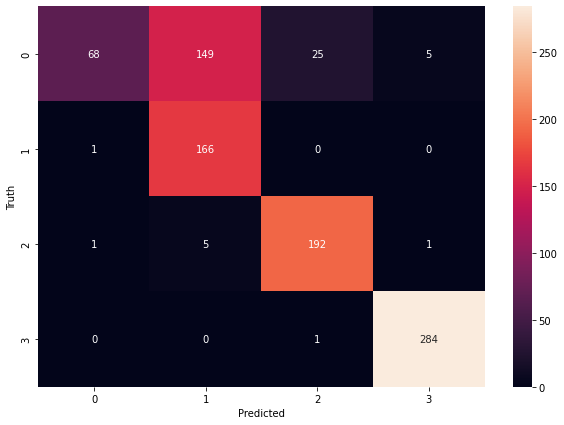

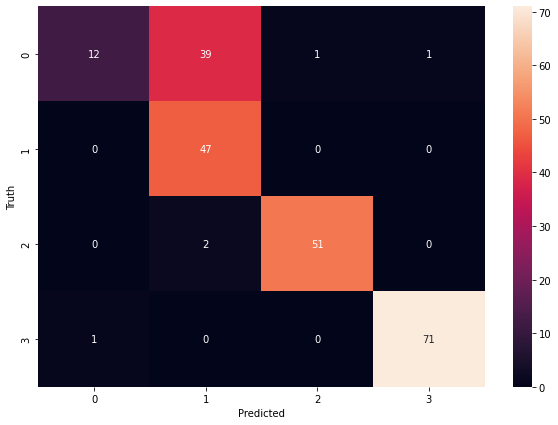

In [ ]:
y_predicted_train = model.predict(X_train)
y_predicted_labels_train = [np.argmax(i) for i in y_predicted_train]
y_train_clf = np.argmax(y_train,axis=1)
cm = tf.math.confusion_matrix(labels=y_train_clf,predictions=y_predicted_labels_train)
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')




y_predicted = model.predict(X_test)
y_predicted_labels = [np.argmax(i) for i in y_predicted]
y_test_clf = np.argmax(y_test,axis=1)
cm = tf.math.confusion_matrix(labels=y_test_clf,predictions=y_predicted_labels)
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
print()


## Second model

In [ ]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=11, kernel_size=(11,11),
                           strides=(4,4), activation='relu',
                           input_shape=(200,200,3)),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(5,5),
                           strides=(2,2), activation='relu',
                           padding="same"),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(3,3),
                           strides=(1,1), activation='relu',
                           padding="same"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(200,activation='relu'),
    tf.keras.layers.Dense(200,activation='relu'),
    tf.keras.layers.Dense(4,activation='softmax')  #using softmax as activation function for the output layer
])
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss= tf.keras.losses.CategoricalCrossentropy() ,metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 48, 48, 11)        4004      
                                                                 
 conv2d_48 (Conv2D)          (None, 24, 24, 11)        3036      
                                                                 
 conv2d_49 (Conv2D)          (None, 24, 24, 11)        1100      
                                                                 
 flatten_7 (Flatten)         (None, 6336)              0         
                                                                 
 dense_36 (Dense)            (None, 200)               1267400   
                                                                 
 dense_37 (Dense)            (None, 200)               40200     
                                                                 
 dense_38 (Dense)            (None, 4)                

### Compile

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'):
  history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=50)

Epoch 1/50
29/29 [==============================] - 1s 30ms/step - loss: 1.3121 - accuracy: 0.3040 - val_loss: 1.1229 - val_accuracy: 0.5156
Epoch 2/50
29/29 [==============================] - 1s 19ms/step - loss: 0.9489 - accuracy: 0.5356 - val_loss: 0.7488 - val_accuracy: 0.7067
Epoch 3/50
29/29 [==============================] - 1s 20ms/step - loss: 0.7354 - accuracy: 0.6748 - val_loss: 0.6850 - val_accuracy: 0.6889
Epoch 4/50
29/29 [==============================] - 1s 17ms/step - loss: 0.6429 - accuracy: 0.7383 - val_loss: 0.6228 - val_accuracy: 0.7511
Epoch 5/50
29/29 [==============================] - 1s 18ms/step - loss: 0.5769 - accuracy: 0.7517 - val_loss: 0.5951 - val_accuracy: 0.7822
Epoch 6/50
29/29 [==============================] - 1s 17ms/step - loss: 0.5259 - accuracy: 0.7661 - val_loss: 1.0096 - val_accuracy: 0.6044
Epoch 7/50
29/29 [==============================] - 1s 18ms/step - loss: 0.6276 - accuracy: 0.7316 - val_loss: 0.6583 - val_accuracy: 0.7022
Epoch 8/50
29

### Report

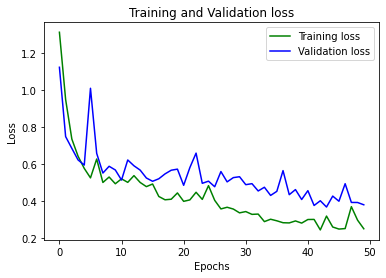

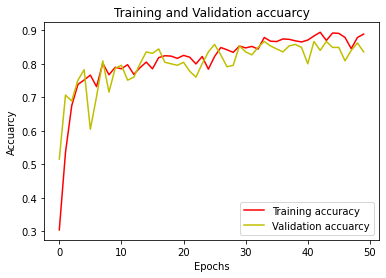


Train report
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       239
           1       0.89      0.73      0.80       170
           2       0.98      0.95      0.97       199
           3       0.99      1.00      0.99       290

    accuracy                           0.92       898
   macro avg       0.92      0.90      0.91       898
weighted avg       0.92      0.92      0.92       898



test report
              precision    recall  f1-score   support

           0       0.74      0.84      0.78        61
           1       0.86      0.70      0.78        44
           2       0.79      0.83      0.81        53
           3       0.97      0.93      0.95        67

    accuracy                           0.84       225
   macro avg       0.84      0.82      0.83       225
weighted avg       0.84      0.84      0.84       225



In [ ]:
report(history, model, X_train, X_test, y_train, y_test)

## Third model

In [ ]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=5,
                           strides=(2,2), activation='relu',
                           input_shape=(200,200,3)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=5,
                           strides=(3,3), activation='relu',
                           padding="valid"),
    tf.keras.layers.Conv2D(filters=64, kernel_size=5,
                           strides=(4,4), activation='relu',
                           padding="valid"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(4,activation='softmax')#using softmax as activation function for the output layer
])
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer = opt, loss= tf.keras.losses.CategoricalCrossentropy() ,metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 98, 98, 16)        1216      
                                                                 
 conv2d_26 (Conv2D)          (None, 32, 32, 32)        12832     
                                                                 
 conv2d_27 (Conv2D)          (None, 7, 7, 64)          51264     
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               401536    
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 4)                

### Compile

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'):
  history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=50)

Epoch 1/50
29/29 [==============================] - 2s 30ms/step - loss: 1.3845 - accuracy: 0.3151 - val_loss: 1.3812 - val_accuracy: 0.3200
Epoch 2/50
29/29 [==============================] - 1s 18ms/step - loss: 1.3686 - accuracy: 0.3174 - val_loss: 1.3691 - val_accuracy: 0.3200
Epoch 3/50
29/29 [==============================] - 0s 17ms/step - loss: 1.3522 - accuracy: 0.3174 - val_loss: 1.3419 - val_accuracy: 0.3200
Epoch 4/50
29/29 [==============================] - 0s 16ms/step - loss: 1.3046 - accuracy: 0.3218 - val_loss: 1.2434 - val_accuracy: 0.4267
Epoch 5/50
29/29 [==============================] - 0s 16ms/step - loss: 1.1496 - accuracy: 0.5011 - val_loss: 1.0338 - val_accuracy: 0.6489
Epoch 6/50
29/29 [==============================] - 0s 16ms/step - loss: 0.9732 - accuracy: 0.6158 - val_loss: 0.8511 - val_accuracy: 0.6756
Epoch 7/50
29/29 [==============================] - 0s 16ms/step - loss: 0.8405 - accuracy: 0.6526 - val_loss: 0.7184 - val_accuracy: 0.7289
Epoch 8/50
29

### Report

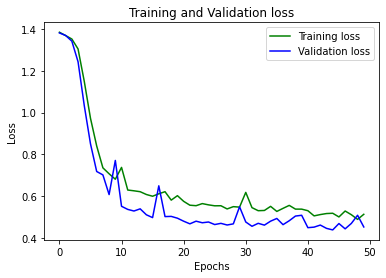

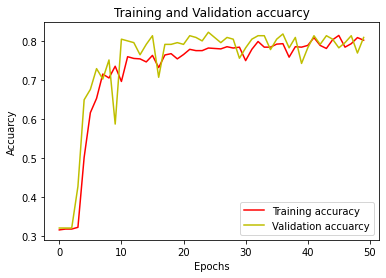


Train report
              precision    recall  f1-score   support

           0       0.73      0.67      0.70       247
           1       0.69      0.67      0.68       167
           2       0.78      0.93      0.85       199
           3       0.97      0.93      0.95       285

    accuracy                           0.81       898
   macro avg       0.79      0.80      0.79       898
weighted avg       0.81      0.81      0.81       898



test report
              precision    recall  f1-score   support

           0       0.62      0.66      0.64        53
           1       0.65      0.64      0.65        47
           2       0.91      0.96      0.94        53
           3       0.99      0.92      0.95        72

    accuracy                           0.81       225
   macro avg       0.79      0.79      0.79       225
weighted avg       0.81      0.81      0.81       225



In [ ]:
report(history, model, X_train, X_test, y_train, y_test)

# *CNN (Max pooling)*

## First model

In [ ]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=11, kernel_size=(11,11),
                           activation='relu',
                           input_shape=(200,200,3), padding='same'),
    keras.layers.BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2),strides=(2, 2)),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(5,5),
                           activation='relu'),
    keras.layers.BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(3,3),
                           activation='relu',strides=(2, 2), padding='same'),
    keras.layers.BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(4,activation='softmax')  #using softmax as activation function for the output layer
])
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss= tf.keras.losses.CategoricalCrossentropy() ,metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 200, 200, 11)      4004      
                                                                 
 batch_normalization (BatchN  (None, 200, 200, 11)     44        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 11)     0         
 )                                                               
                                                                 
 conv2d_29 (Conv2D)          (None, 96, 96, 11)        3036      
                                                                 
 batch_normalization_1 (Batc  (None, 96, 96, 11)       44        
 hNormalization)                                                 
                                                      

### Compile

In [ ]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=50)

Epoch 1/50
29/29 [==============================] - 3s 52ms/step - loss: 0.7630 - accuracy: 0.6993 - val_loss: 1.3999 - val_accuracy: 0.2089
Epoch 2/50
29/29 [==============================] - 1s 34ms/step - loss: 0.3530 - accuracy: 0.8630 - val_loss: 1.5107 - val_accuracy: 0.2089
Epoch 3/50
29/29 [==============================] - 1s 33ms/step - loss: 0.3548 - accuracy: 0.8630 - val_loss: 1.6147 - val_accuracy: 0.2089
Epoch 4/50
29/29 [==============================] - 1s 33ms/step - loss: 0.2090 - accuracy: 0.9143 - val_loss: 1.7207 - val_accuracy: 0.2089
Epoch 5/50
29/29 [==============================] - 1s 34ms/step - loss: 0.1871 - accuracy: 0.9376 - val_loss: 2.2110 - val_accuracy: 0.2089
Epoch 6/50
29/29 [==============================] - 1s 34ms/step - loss: 0.2865 - accuracy: 0.8831 - val_loss: 2.6713 - val_accuracy: 0.2089
Epoch 7/50
29/29 [==============================] - 1s 34ms/step - loss: 0.1427 - accuracy: 0.9465 - val_loss: 3.3011 - val_accuracy: 0.2089
Epoch 8/50
29

### Report

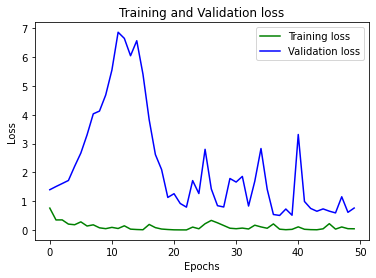

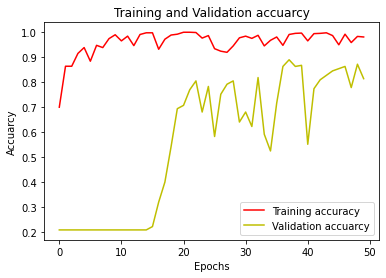


Train report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       247
           1       0.98      0.99      0.99       167
           2       0.99      0.99      0.99       199
           3       1.00      1.00      1.00       285

    accuracy                           0.99       898
   macro avg       0.99      0.99      0.99       898
weighted avg       0.99      0.99      0.99       898



test report
              precision    recall  f1-score   support

           0       0.63      0.72      0.67        53
           1       0.74      0.74      0.74        47
           2       0.84      0.79      0.82        53
           3       1.00      0.94      0.97        72

    accuracy                           0.81       225
   macro avg       0.80      0.80      0.80       225
weighted avg       0.82      0.81      0.82       225



In [ ]:
report(history, model, X_train, X_test, y_train, y_test)

## Second model

In [ ]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=11, kernel_size=(11,11),
                           activation='relu',
                           input_shape=(200,200,3), padding='same'),
    keras.layers.BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3),strides=(2, 2)),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(5,5),
                           activation='relu',strides=(2, 2), padding='same'),
    keras.layers.BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(3,3),
                           activation='relu',strides=(2, 2), padding='same'),
    keras.layers.BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(150,activation='relu'),
    tf.keras.layers.Dense(150,activation='relu'),
    tf.keras.layers.Dense(4,activation='softmax')  #using softmax as activation function for the output layer
])
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss= tf.keras.losses.CategoricalCrossentropy() ,metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 200, 200, 11)      4004      
                                                                 
 batch_normalization_3 (Batc  (None, 200, 200, 11)     44        
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 99, 99, 11)       0         
 2D)                                                             
                                                                 
 conv2d_32 (Conv2D)          (None, 50, 50, 11)        3036      
                                                                 
 batch_normalization_4 (Batc  (None, 50, 50, 11)       44        
 hNormalization)                                                 
                                                      

### Compile

In [ ]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=50)

Epoch 1/50
29/29 [==============================] - 2s 42ms/step - loss: 0.8559 - accuracy: 0.6258 - val_loss: 1.4005 - val_accuracy: 0.2089
Epoch 2/50
29/29 [==============================] - 1s 31ms/step - loss: 0.5527 - accuracy: 0.7506 - val_loss: 1.4471 - val_accuracy: 0.2089
Epoch 3/50
29/29 [==============================] - 1s 32ms/step - loss: 0.4818 - accuracy: 0.7840 - val_loss: 1.4745 - val_accuracy: 0.2089
Epoch 4/50
29/29 [==============================] - 1s 31ms/step - loss: 0.4510 - accuracy: 0.8207 - val_loss: 1.4809 - val_accuracy: 0.2089
Epoch 5/50
29/29 [==============================] - 1s 32ms/step - loss: 0.4467 - accuracy: 0.7996 - val_loss: 1.5615 - val_accuracy: 0.2089
Epoch 6/50
29/29 [==============================] - 1s 31ms/step - loss: 0.3923 - accuracy: 0.8307 - val_loss: 1.6909 - val_accuracy: 0.2089
Epoch 7/50
29/29 [==============================] - 1s 32ms/step - loss: 0.3768 - accuracy: 0.8530 - val_loss: 1.8763 - val_accuracy: 0.2089
Epoch 8/50
29

### Report

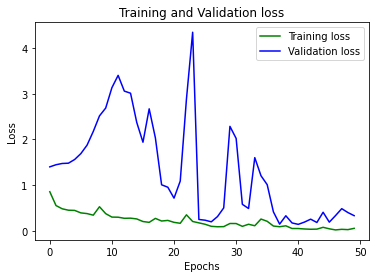

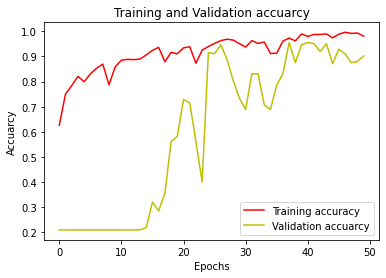


Train report
              precision    recall  f1-score   support

           0       1.00      0.66      0.79       247
           1       0.86      0.96      0.91       167
           2       0.75      1.00      0.86       199
           3       1.00      1.00      1.00       285

    accuracy                           0.90       898
   macro avg       0.90      0.90      0.89       898
weighted avg       0.92      0.90      0.89       898



test report
              precision    recall  f1-score   support

           0       1.00      0.64      0.78        53
           1       0.80      0.94      0.86        47
           2       0.83      1.00      0.91        53
           3       1.00      1.00      1.00        72

    accuracy                           0.90       225
   macro avg       0.91      0.89      0.89       225
weighted avg       0.92      0.90      0.90       225



In [ ]:
report(history, model, X_train, X_test, y_train, y_test)

# *CNN (AVG pooling)*

## First model

In [ ]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=11, kernel_size=(11,11),
                           activation='relu',
                           input_shape=(200,200,3), padding='same'),
    keras.layers.BatchNormalization(),
    AveragePooling2D(pool_size=(2, 2),strides=(2, 2)),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(5,5),
                           activation='relu',strides=(2, 2), padding='same'),
    keras.layers.BatchNormalization(),
    AveragePooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(3,3),
                           activation='relu',strides=(2, 2), padding='same'),
    keras.layers.BatchNormalization(),
    AveragePooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(4,activation='softmax') #using softmax as activation function for the output layer
])
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss= tf.keras.losses.CategoricalCrossentropy() ,metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_59 (Conv2D)          (None, 200, 200, 11)      4004      
                                                                 
 batch_normalization_10 (Bat  (None, 200, 200, 11)     44        
 chNormalization)                                                
                                                                 
 average_pooling2d (AverageP  (None, 100, 100, 11)     0         
 ooling2D)                                                       
                                                                 
 conv2d_60 (Conv2D)          (None, 50, 50, 11)        3036      
                                                                 
 batch_normalization_11 (Bat  (None, 50, 50, 11)       44        
 chNormalization)                                                
                                                     

### Compile

In [ ]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=80)

Epoch 1/80
29/29 [==============================] - 2s 45ms/step - loss: 0.7269 - accuracy: 0.7038 - val_loss: 1.4200 - val_accuracy: 0.1956
Epoch 2/80
29/29 [==============================] - 1s 32ms/step - loss: 0.4602 - accuracy: 0.8118 - val_loss: 1.5545 - val_accuracy: 0.1956
Epoch 3/80
29/29 [==============================] - 1s 32ms/step - loss: 0.6547 - accuracy: 0.7550 - val_loss: 1.5833 - val_accuracy: 0.1956
Epoch 4/80
29/29 [==============================] - 1s 32ms/step - loss: 0.4127 - accuracy: 0.8452 - val_loss: 1.8231 - val_accuracy: 0.1956
Epoch 5/80
29/29 [==============================] - 1s 32ms/step - loss: 0.3060 - accuracy: 0.8909 - val_loss: 2.2603 - val_accuracy: 0.1956
Epoch 6/80
29/29 [==============================] - 1s 32ms/step - loss: 0.3788 - accuracy: 0.8530 - val_loss: 3.0109 - val_accuracy: 0.1956
Epoch 7/80
29/29 [==============================] - 1s 32ms/step - loss: 0.2541 - accuracy: 0.8987 - val_loss: 3.7617 - val_accuracy: 0.1956
Epoch 8/80
29

### Report

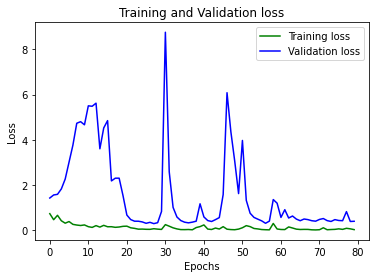

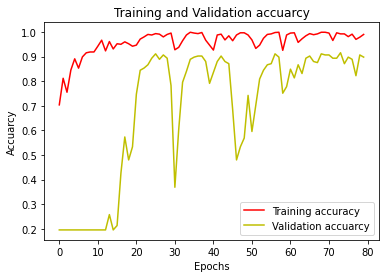


Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       239
           1       1.00      1.00      1.00       170
           2       1.00      0.99      1.00       199
           3       1.00      1.00      1.00       290

    accuracy                           1.00       898
   macro avg       1.00      1.00      1.00       898
weighted avg       1.00      1.00      1.00       898



test report
              precision    recall  f1-score   support

           0       0.81      0.95      0.87        61
           1       0.88      0.68      0.77        44
           2       0.94      0.94      0.94        53
           3       0.97      0.96      0.96        67

    accuracy                           0.90       225
   macro avg       0.90      0.88      0.89       225
weighted avg       0.90      0.90      0.90       225



In [ ]:
report(history, model, X_train, X_test, y_train, y_test,epoch=80)

## Second model

In [ ]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=11, kernel_size=(11,11),
                           activation='relu',
                           input_shape=(200,200,3), padding='valid'),
    keras.layers.BatchNormalization(),
    AveragePooling2D(pool_size=(2, 2),strides=(2, 2)),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(5,5),
                           activation='relu',strides=(2, 2), padding='valid'),
    keras.layers.BatchNormalization(),
    AveragePooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(3,3),
                           activation='relu',strides=(2, 2), padding='valid'),
    keras.layers.BatchNormalization(),
    AveragePooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation='relu'),
    #tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(4,activation='softmax') #using softmax as activation function for the output layer
])
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss= tf.keras.losses.CategoricalCrossentropy() ,metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_62 (Conv2D)          (None, 190, 190, 11)      4004      
                                                                 
 batch_normalization_13 (Bat  (None, 190, 190, 11)     44        
 chNormalization)                                                
                                                                 
 average_pooling2d_3 (Averag  (None, 95, 95, 11)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_63 (Conv2D)          (None, 46, 46, 11)        3036      
                                                                 
 batch_normalization_14 (Bat  (None, 46, 46, 11)       44        
 chNormalization)                                                
                                                     

### Compile

In [ ]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=80)

Epoch 1/80
29/29 [==============================] - 3s 49ms/step - loss: 0.7980 - accuracy: 0.6592 - val_loss: 1.4196 - val_accuracy: 0.1956
Epoch 2/80
29/29 [==============================] - 1s 30ms/step - loss: 0.5206 - accuracy: 0.7739 - val_loss: 1.5803 - val_accuracy: 0.1956
Epoch 3/80
29/29 [==============================] - 1s 30ms/step - loss: 0.4785 - accuracy: 0.7951 - val_loss: 1.7753 - val_accuracy: 0.1956
Epoch 4/80
29/29 [==============================] - 1s 30ms/step - loss: 0.4440 - accuracy: 0.8062 - val_loss: 2.1471 - val_accuracy: 0.1956
Epoch 5/80
29/29 [==============================] - 1s 30ms/step - loss: 0.4187 - accuracy: 0.8174 - val_loss: 2.3162 - val_accuracy: 0.2711
Epoch 6/80
29/29 [==============================] - 1s 30ms/step - loss: 0.3895 - accuracy: 0.8307 - val_loss: 2.5844 - val_accuracy: 0.2711
Epoch 7/80
29/29 [==============================] - 1s 29ms/step - loss: 0.3872 - accuracy: 0.8408 - val_loss: 2.8482 - val_accuracy: 0.1956
Epoch 8/80
29

### Report

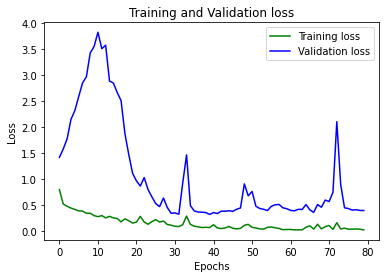

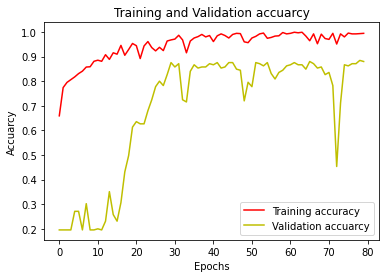


Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       239
           1       1.00      1.00      1.00       170
           2       1.00      1.00      1.00       199
           3       1.00      1.00      1.00       290

    accuracy                           1.00       898
   macro avg       1.00      1.00      1.00       898
weighted avg       1.00      1.00      1.00       898



test report
              precision    recall  f1-score   support

           0       0.83      0.85      0.84        61
           1       0.84      0.73      0.78        44
           2       0.85      0.94      0.89        53
           3       0.98      0.96      0.97        67

    accuracy                           0.88       225
   macro avg       0.87      0.87      0.87       225
weighted avg       0.88      0.88      0.88       225



In [ ]:
report(history, model, X_train, X_test, y_train, y_test,epoch=80)

## Third model

In [ ]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=11, kernel_size=(11,11),
                           activation='relu',
                           input_shape=(200,200,3), dilation_rate=2),
    keras.layers.BatchNormalization(),
    AveragePooling2D(pool_size=(2, 2),strides=(2, 2)),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(5,5),
                           activation='relu',strides=(2, 2), padding='valid'),
    keras.layers.BatchNormalization(),
    AveragePooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(3,3),
                           activation='relu',strides=(2, 2), padding='valid'),
    keras.layers.BatchNormalization(),
    AveragePooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(4,activation='softmax') #using softmax as activation function for the output layer
])
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer = opt, loss= tf.keras.losses.CategoricalCrossentropy() ,metrics=['accuracy'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 180, 180, 11)      4004      
                                                                 
 batch_normalization_16 (Bat  (None, 180, 180, 11)     44        
 chNormalization)                                                
                                                                 
 average_pooling2d_6 (Averag  (None, 90, 90, 11)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_66 (Conv2D)          (None, 43, 43, 11)        3036      
                                                                 
 batch_normalization_17 (Bat  (None, 43, 43, 11)       44        
 chNormalization)                                                
                                                     

### Compile

In [ ]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=80)

Epoch 1/80
29/29 [==============================] - 3s 50ms/step - loss: 0.9406 - accuracy: 0.6492 - val_loss: 1.2840 - val_accuracy: 0.3067
Epoch 2/80
29/29 [==============================] - 1s 35ms/step - loss: 0.5399 - accuracy: 0.7784 - val_loss: 1.3333 - val_accuracy: 0.4800
Epoch 3/80
29/29 [==============================] - 1s 35ms/step - loss: 0.5629 - accuracy: 0.7684 - val_loss: 1.9314 - val_accuracy: 0.3156
Epoch 4/80
29/29 [==============================] - 1s 35ms/step - loss: 0.4983 - accuracy: 0.8096 - val_loss: 4.2374 - val_accuracy: 0.1956
Epoch 5/80
29/29 [==============================] - 1s 34ms/step - loss: 0.5268 - accuracy: 0.7984 - val_loss: 3.1047 - val_accuracy: 0.1956
Epoch 6/80
29/29 [==============================] - 1s 35ms/step - loss: 0.4053 - accuracy: 0.8352 - val_loss: 3.7557 - val_accuracy: 0.1956
Epoch 7/80
29/29 [==============================] - 1s 35ms/step - loss: 0.4442 - accuracy: 0.8151 - val_loss: 6.8011 - val_accuracy: 0.1956
Epoch 8/80
29

### Report

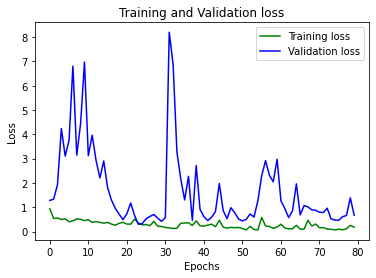

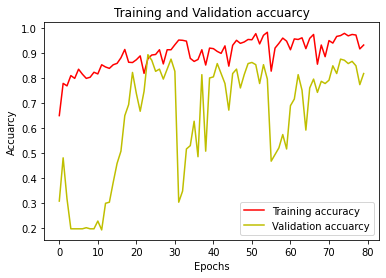


Train report
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       239
           1       0.96      0.92      0.94       170
           2       0.88      0.99      0.94       199
           3       1.00      0.99      0.99       290

    accuracy                           0.96       898
   macro avg       0.95      0.95      0.95       898
weighted avg       0.96      0.96      0.96       898



test report
              precision    recall  f1-score   support

           0       0.72      0.69      0.71        61
           1       0.78      0.66      0.72        44
           2       0.75      0.96      0.84        53
           3       1.00      0.93      0.96        67

    accuracy                           0.82       225
   macro avg       0.81      0.81      0.81       225
weighted avg       0.82      0.82      0.82       225



In [ ]:
report(history, model, X_train, X_test, y_train, y_test,epoch=80)

# *RESNET*

## Identity Block Function

In [ ]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
  F1, F2, F3 = filters  #using three filters
  X_shortcut = X
  cache = []
  X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
  X = BatchNormalization(axis = 3)(X, training = training) # Default axis
  X = Activation('relu')(X)
  X = Conv2D(filters = F2, kernel_size = f,strides = (1, 1),padding='same',kernel_initializer = initializer(seed=0))(X)
  X = BatchNormalization(axis = 3)(X, training=training)
  X = Activation('relu')(X)
  X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
  X = BatchNormalization(axis = 3)(X, training=training)
  X = Add()([X_shortcut,X])
  X = Activation('relu')(X)
  return X

## Convolutional Block Function

In [ ]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
  F1, F2, F3 = filters
  X_shortcut = X
  X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
  X = BatchNormalization(axis = 3)(X, training=training)
  X = Activation('relu')(X)
  X = Conv2D(filters = F2, kernel_size = f,strides = (1, 1),padding='same',kernel_initializer = initializer(seed=0))(X)
  X = BatchNormalization(axis = 3)(X, training=training)
  X = Activation('relu')(X)
  X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
  X = BatchNormalization(axis = 3)(X, training=training)
  X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
  X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)
  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)
  return X

## Build Model

In [ ]:
def ResNet50(input_shape = (200, 200, 3), classes = 4):

  X_input = Input(input_shape)
  X = ZeroPadding2D((3, 3))(X_input)
  X = Conv2D(200, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((3, 3), strides=(2, 2))(X)
  X = convolutional_block(X, f = 3, filters = [64, 64, 64], s = 1)
  X = identity_block(X, 3, [64, 64, 64])
  X = identity_block(X, 3, [64, 64, 64])
  X = convolutional_block(X, f = 3, filters = [128,128,128], s = 2)
  X = identity_block(X, 3,  [128,128,128])
  X = identity_block(X, 3,  [128,128,128])
  X = identity_block(X, 3,  [128,128,128])
  X = convolutional_block(X, f = 3, filters = [256, 256, 256], s = 2)
  X = identity_block(X, 3, [256, 256, 256])
  X = identity_block(X, 3, [256, 256, 256])
  X = identity_block(X, 3, [256, 256, 256])
  X = identity_block(X, 3, [256, 256, 256])
  X = identity_block(X, 3, [256, 256, 256])
  X = convolutional_block(X, f = 3, filters = [512, 512, 512], s = 2)
  X = identity_block(X, 3, [512, 512, 512])
  X = identity_block(X, 3, [512, 512, 512])
  X = AveragePooling2D((2, 2))(X)
  X = Flatten()(X)
  X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
  model = Model(inputs = X_input, outputs = X)

  return model

## Compile

In [ ]:
model = ResNet50(input_shape=(200,200,3),classes=4)
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss= tf.keras.losses.CategoricalCrossentropy() ,metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 206, 206, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d_68 (Conv2D)             (None, 100, 100, 20  29600       ['zero_padding2d[0][0]']         
                                0)                                                                
                                                                                              

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'):
  history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_test, y_test))

Epoch 1/50
29/29 [==============================] - 14s 272ms/step - loss: 1.4657 - accuracy: 0.5612 - val_loss: 0.7745 - val_accuracy: 0.6622
Epoch 2/50
29/29 [==============================] - 6s 195ms/step - loss: 0.6424 - accuracy: 0.7428 - val_loss: 0.4769 - val_accuracy: 0.8400
Epoch 3/50
29/29 [==============================] - 6s 195ms/step - loss: 0.4383 - accuracy: 0.8229 - val_loss: 0.8333 - val_accuracy: 0.7111
Epoch 4/50
29/29 [==============================] - 6s 197ms/step - loss: 0.6273 - accuracy: 0.7784 - val_loss: 0.4947 - val_accuracy: 0.8178
Epoch 5/50
29/29 [==============================] - 6s 204ms/step - loss: 0.4783 - accuracy: 0.8274 - val_loss: 0.5442 - val_accuracy: 0.7733
Epoch 6/50
29/29 [==============================] - 6s 198ms/step - loss: 1.2882 - accuracy: 0.7528 - val_loss: 0.4974 - val_accuracy: 0.8356
Epoch 7/50
29/29 [==============================] - 6s 196ms/step - loss: 0.4712 - accuracy: 0.8196 - val_loss: 0.4240 - val_accuracy: 0.8444
Epoch

## Report

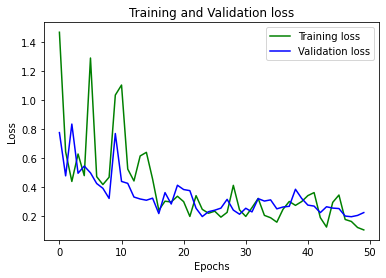

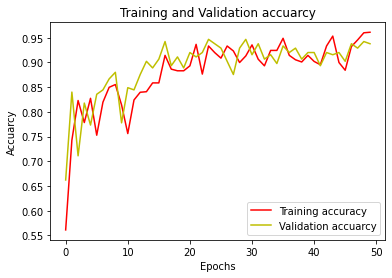


Train report
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       239
           1       0.96      0.96      0.96       170
           2       0.98      0.93      0.96       199
           3       0.99      0.99      0.99       290

    accuracy                           0.97       898
   macro avg       0.97      0.97      0.97       898
weighted avg       0.97      0.97      0.97       898



test report
              precision    recall  f1-score   support

           0       0.88      0.97      0.92        61
           1       1.00      0.93      0.96        44
           2       0.89      0.89      0.89        53
           3       1.00      0.96      0.98        67

    accuracy                           0.94       225
   macro avg       0.94      0.94      0.94       225
weighted avg       0.94      0.94      0.94       225



In [ ]:
report(history, model, X_train, X_test, y_train, y_test)

# *Inception*

## Inception module

In [ ]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):

    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)

    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)

    return output

In [ ]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [ ]:
input_layer = Input(shape=(200, 200, 3))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')



x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)



x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(4, activation='softmax', name='auxilliary_output_1')(x1)





x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(4, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)


x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(4, activation='softmax', name='output')(x)

In [ ]:
model = Model(input_layer, [x, x1, x2], name='inception_v1')

In [ ]:
model.summary()

Model: "inception_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1_7x7/2 (Conv2D)          (None, 100, 100, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pool_1_3x3/2 (MaxPooling2D  (None, 50, 50, 64)  0           ['conv_1_7x7/2[0][0]']           
 )                                                                                     

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss= tf.keras.losses.CategoricalCrossentropy() ,metrics=['accuracy'])
with tf.device('/GPU:0'):
  history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=50)

Epoch 1/50
29/29 [==============================] - 8s 137ms/step - loss: 4.7184 - output_loss: 1.8196 - auxilliary_output_1_loss: 1.4160 - auxilliary_output_2_loss: 1.4828 - output_accuracy: 0.2650 - auxilliary_output_1_accuracy: 0.2773 - auxilliary_output_2_accuracy: 0.2517 - val_loss: 4.1931 - val_output_loss: 1.4392 - val_auxilliary_output_1_loss: 1.3763 - val_auxilliary_output_2_loss: 1.3777 - val_output_accuracy: 0.2978 - val_auxilliary_output_1_accuracy: 0.2978 - val_auxilliary_output_2_accuracy: 0.2978
Epoch 2/50
29/29 [==============================] - 2s 71ms/step - loss: 4.1587 - output_loss: 1.4074 - auxilliary_output_1_loss: 1.3735 - auxilliary_output_2_loss: 1.3778 - output_accuracy: 0.2684 - auxilliary_output_1_accuracy: 0.3096 - auxilliary_output_2_accuracy: 0.2895 - val_loss: 4.2048 - val_output_loss: 1.3974 - val_auxilliary_output_1_loss: 1.4101 - val_auxilliary_output_2_loss: 1.3973 - val_output_accuracy: 0.2978 - val_auxilliary_output_1_accuracy: 0.2978 - val_auxill

dict_keys(['loss', 'output_loss', 'auxilliary_output_1_loss', 'auxilliary_output_2_loss', 'output_accuracy', 'auxilliary_output_1_accuracy', 'auxilliary_output_2_accuracy', 'val_loss', 'val_output_loss', 'val_auxilliary_output_1_loss', 'val_auxilliary_output_2_loss', 'val_output_accuracy', 'val_auxilliary_output_1_accuracy', 'val_auxilliary_output_2_accuracy'])



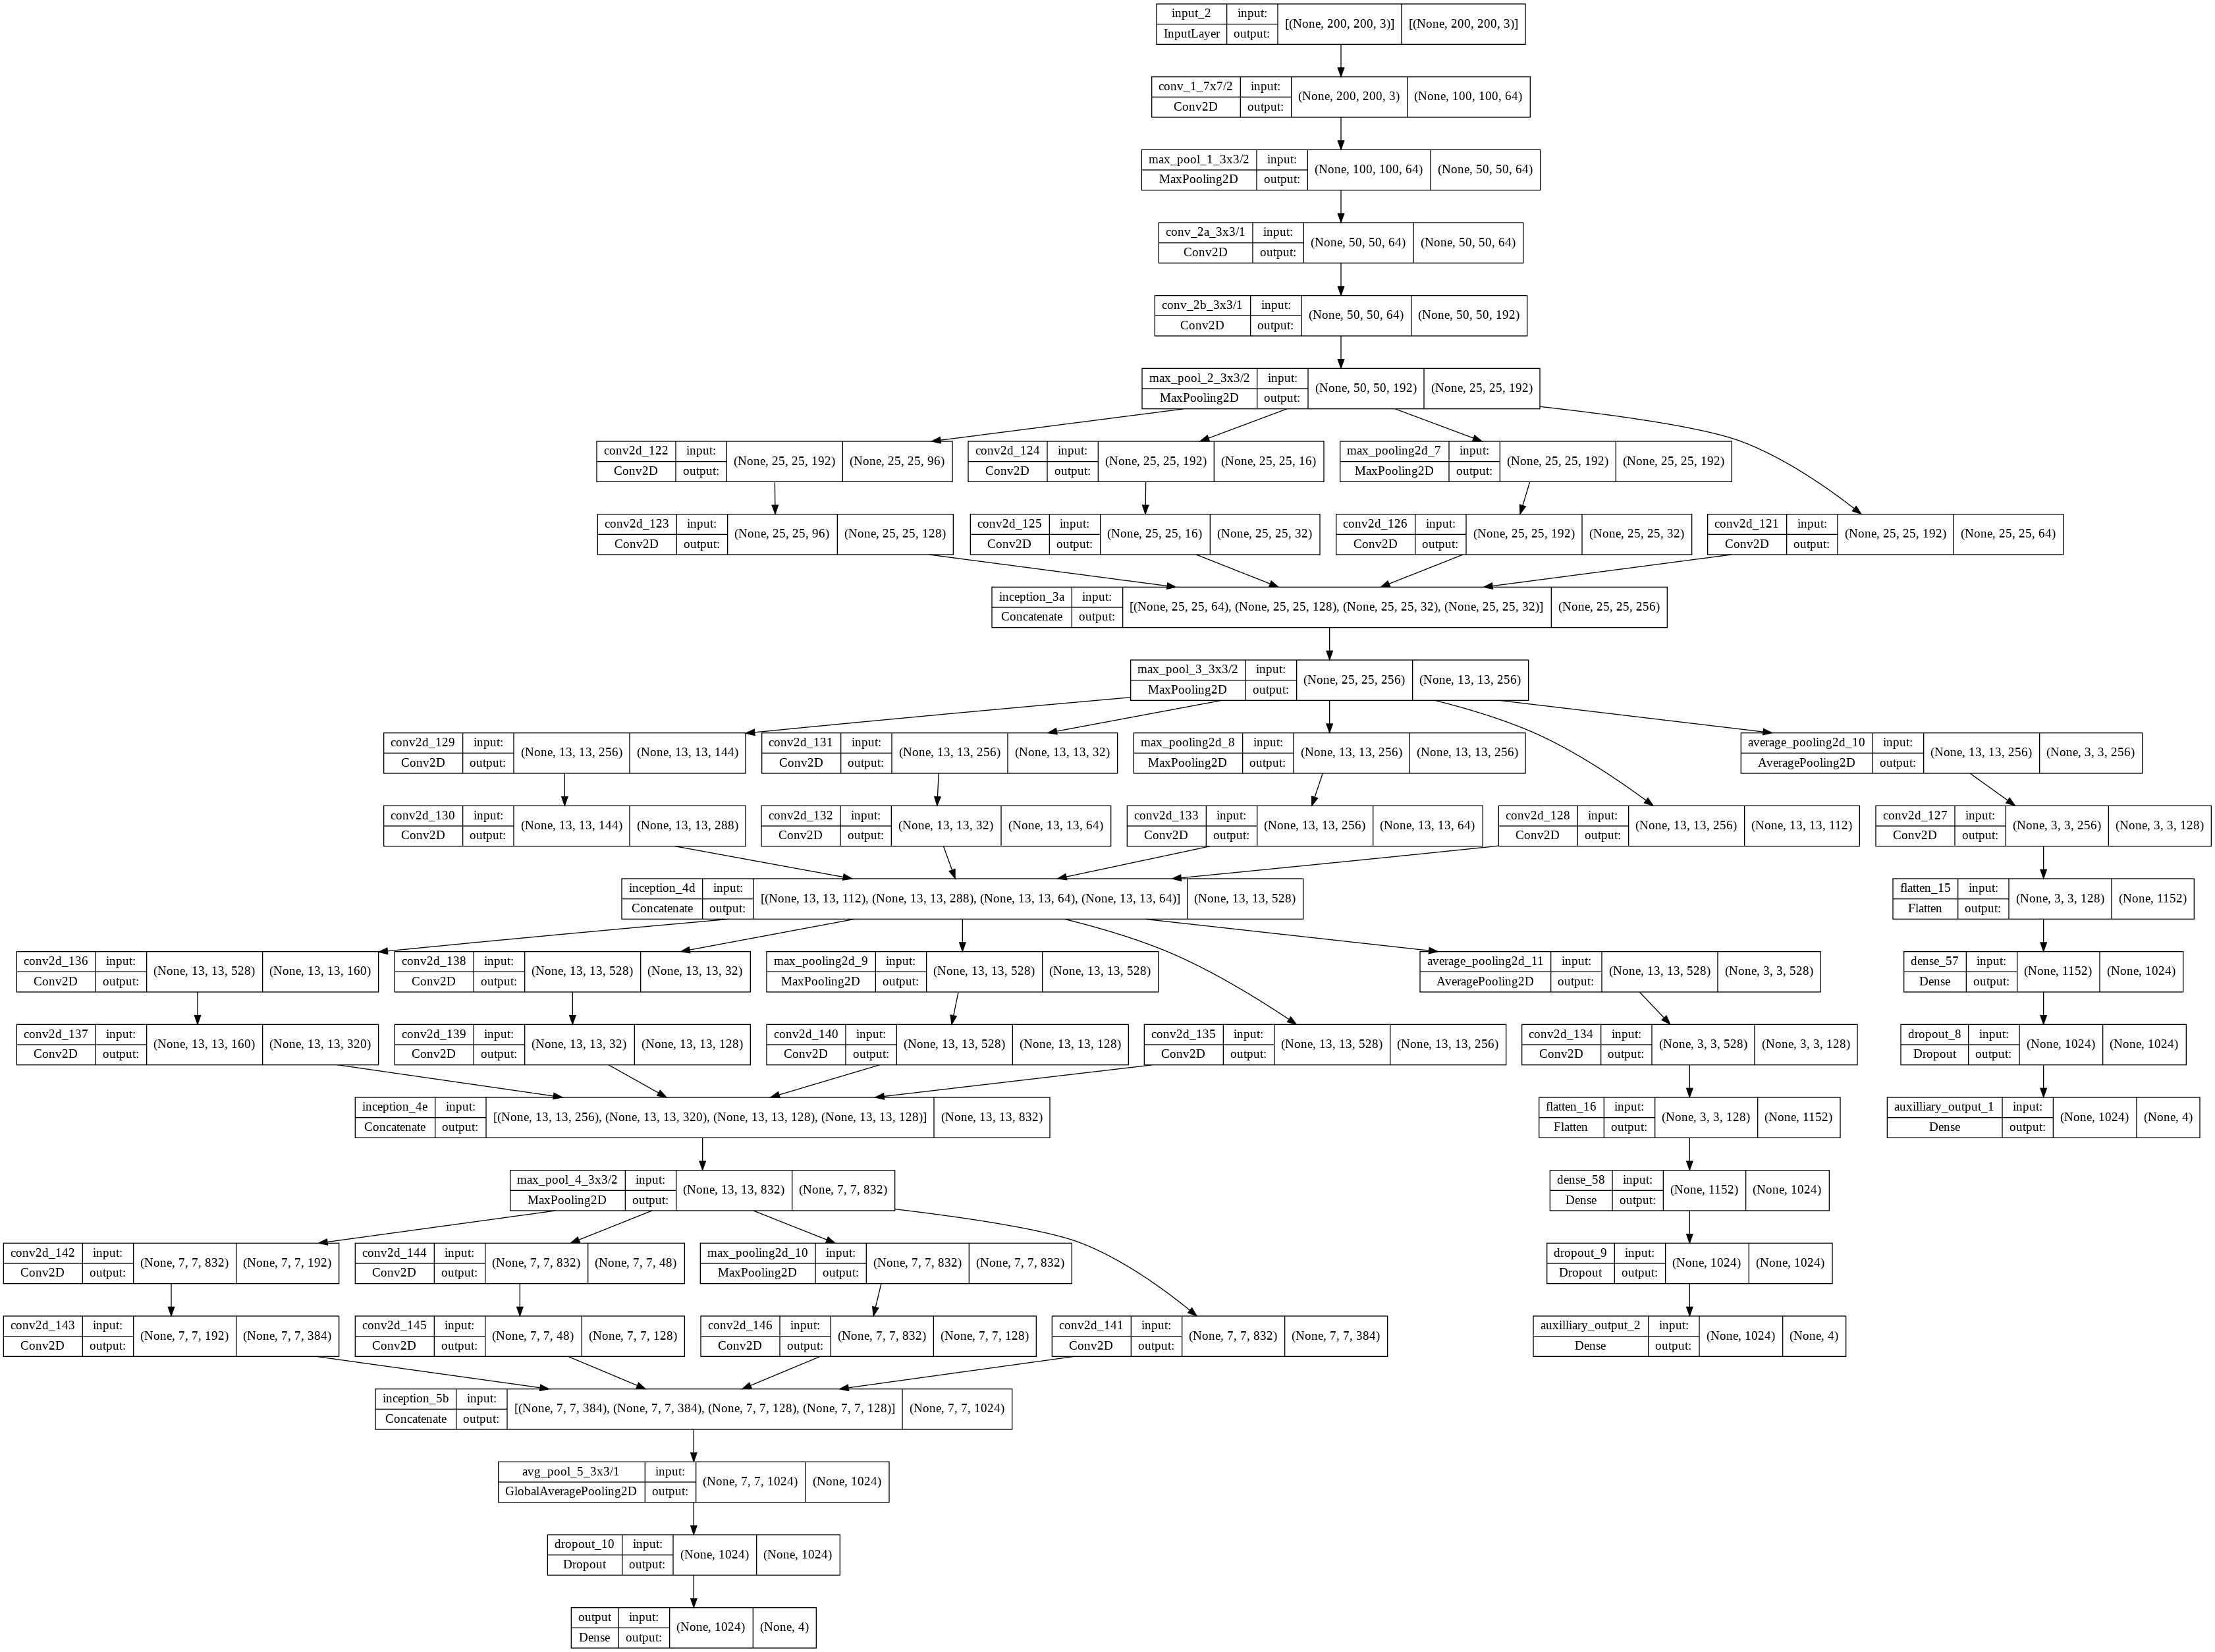

In [ ]:
print(history.history.keys())
print()
plot_model(model, show_shapes=True, to_file='vgg_block.png')

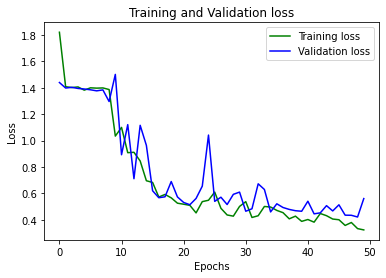

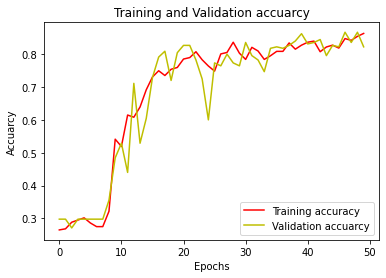


Train report
              precision    recall  f1-score   support

           0       0.75      0.66      0.70       239
           1       0.80      0.59      0.68       170
           2       0.70      0.99      0.82       199
           3       1.00      0.97      0.98       290

    accuracy                           0.82       898
   macro avg       0.81      0.80      0.80       898
weighted avg       0.83      0.82      0.81       898



test report
              precision    recall  f1-score   support

           0       0.77      0.59      0.67        61
           1       0.78      0.66      0.72        44
           2       0.66      0.98      0.79        53
           3       1.00      0.93      0.96        67

    accuracy                           0.80       225
   macro avg       0.80      0.79      0.78       225
weighted avg       0.81      0.80      0.79       225



In [ ]:
report_inc(history, model, X_train, X_test, y_train, y_test)

# *K fold*


## First model

In [ ]:
# model with 6 layers
# concat both inputs of train and test
inputs = np.concatenate((X_train, X_test), axis=0)

# concat both outputs of train and test
outputs = np.concatenate((y_train, y_test), axis=0)
accuracy_per_fold = []
loss_per_fold = []

  # create kfold with k = 5
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_number = 1
for train, test in kfold.split(inputs, outputs):

  model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=11, kernel_size=(11,11),
                           activation='relu',
                           input_shape=(200,200,3), padding='same'),
    keras.layers.BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2),strides=(2, 2)),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(5,5),
                           activation='relu'),
    keras.layers.BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(3,3),
                           activation='relu',strides=(2, 2), padding='same'),
    keras.layers.BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(4,activation='softmax')
])
  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer = opt, loss= tf.keras.losses.CategoricalCrossentropy() ,metrics=['accuracy'])
  # train the model
  with tf.device('/GPU:0'):
    history = model.fit(inputs[train], outputs[train],epochs=50)

  # compute score of the model (loss and accuracy)
  scores = model.evaluate(inputs[test], outputs[test], verbose=0)
  print()
  print(f'Score for fold {fold_number}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  print()
  Confusion(model, inputs[train], inputs[test], outputs[train], outputs[test])

  # draw the confusion matrix
  #f1(model, inputs[train], inputs[test], outputs[train], outputs[test])

  # append accuracy and loss of each fold
  accuracy_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  fold_number = fold_number + 1

print('Average scores for all folds:')

# calculate mean of all accuracies
print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')

# calculate mean of all losses
print(f'> Loss: {np.mean(loss_per_fold)}')

Epoch 1/50
29/29 [==============================] - 2s 33ms/step - loss: 0.6878 - accuracy: 0.7283
Epoch 2/50
29/29 [==============================] - 1s 29ms/step - loss: 0.3928 - accuracy: 0.8419
Epoch 3/50
29/29 [==============================] - 1s 30ms/step - loss: 0.3311 - accuracy: 0.8697
Epoch 4/50
29/29 [==============================] - 1s 29ms/step - loss: 0.2921 - accuracy: 0.8875
Epoch 5/50
29/29 [==============================] - 1s 30ms/step - loss: 0.2335 - accuracy: 0.9109
Epoch 6/50
29/29 [==============================] - 1s 30ms/step - loss: 0.2382 - accuracy: 0.9243
Epoch 7/50
29/29 [==============================] - 1s 29ms/step - loss: 0.2348 - accuracy: 0.9232
Epoch 8/50
29/29 [==============================] - 1s 29ms/step - loss: 0.1266 - accuracy: 0.9588
Epoch 9/50
29/29 [==============================] - 1s 29ms/step - loss: 0.1168 - accuracy: 0.9543
Epoch 10/50
29/29 [==============================] - 1s 30ms/step - loss: 0.0636 - accuracy: 0.9833
Epoch 11/

## Second model

In [ ]:
# model with 6 layers
# concat both inputs of train and test
inputs = np.concatenate((X_train, X_test), axis=0)

# concat both outputs of train and test
outputs = np.concatenate((y_train, y_test), axis=0)
accuracy_per_fold = []
loss_per_fold = []

  # create kfold with k = 5
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_number = 1
for train, test in kfold.split(inputs, outputs):

  model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=11, kernel_size=(11,11),
                           activation='relu',
                           input_shape=(200,200,3), padding='same'),
    keras.layers.BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3),strides=(2, 2)),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(5,5),
                           activation='relu'),
    keras.layers.BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(3,3),
                           activation='relu',strides=(2, 2), padding='same'),
    keras.layers.BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(150,activation='relu'),
    tf.keras.layers.Dense(150,activation='relu'),
    tf.keras.layers.Dense(4,activation='softmax')
])
  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer = opt, loss= tf.keras.losses.CategoricalCrossentropy() ,metrics=['accuracy'])
  # train the model
  with tf.device('/GPU:0'):
    history = model.fit(inputs[train], outputs[train],epochs=50)

  # compute score of the model (loss and accuracy)
  scores = model.evaluate(inputs[test], outputs[test], verbose=0)
  print()
  print(f'Score for fold {fold_number}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  print()
  Confusion(model, inputs[train], inputs[test], outputs[train], outputs[test])

  # draw the confusion matrix
  #f1(model, inputs[train], inputs[test], outputs[train], outputs[test])

  # append accuracy and loss of each fold
  accuracy_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  fold_number = fold_number + 1

print('Average scores for all folds:')

# calculate mean of all accuracies
print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')

# calculate mean of all losses
print(f'> Loss: {np.mean(loss_per_fold)}')

Epoch 1/50
29/29 [==============================] - 2s 32ms/step - loss: 0.7911 - accuracy: 0.6793
Epoch 2/50
29/29 [==============================] - 1s 30ms/step - loss: 0.5350 - accuracy: 0.8007
Epoch 3/50
29/29 [==============================] - 1s 30ms/step - loss: 0.3985 - accuracy: 0.8363
Epoch 4/50
29/29 [==============================] - 1s 29ms/step - loss: 0.3106 - accuracy: 0.8842
Epoch 5/50
29/29 [==============================] - 1s 30ms/step - loss: 0.2957 - accuracy: 0.8797
Epoch 6/50
29/29 [==============================] - 1s 29ms/step - loss: 0.2398 - accuracy: 0.9131
Epoch 7/50
29/29 [==============================] - 1s 30ms/step - loss: 0.2678 - accuracy: 0.9076
Epoch 8/50
29/29 [==============================] - 1s 29ms/step - loss: 0.2863 - accuracy: 0.8964
Epoch 9/50
29/29 [==============================] - 1s 30ms/step - loss: 0.1786 - accuracy: 0.9298
Epoch 10/50
29/29 [==============================] - 1s 30ms/step - loss: 0.1221 - accuracy: 0.9577
Epoch 11/

## Third model

In [ ]:
# model with 6 layers
# concat both inputs of train and test
inputs = np.concatenate((X_train, X_test), axis=0)

# concat both outputs of train and test
outputs = np.concatenate((y_train, y_test), axis=0)
accuracy_per_fold = []
loss_per_fold = []

  # create kfold with k = 5
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_number = 1
for train, test in kfold.split(inputs, outputs):
  model = ResNet50(input_shape=(200,200,3),classes=4)
  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer = opt, loss= tf.keras.losses.CategoricalCrossentropy() ,metrics=['accuracy'])
  # train the model
  with tf.device('/GPU:0'):
    history = model.fit(inputs[train], outputs[train],epochs=50)

  # compute score of the model (loss and accuracy)
  scores = model.evaluate(inputs[test], outputs[test], verbose=0)
  print()
  print(f'Score for fold {fold_number}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  print()
  Confusion(model, inputs[train], inputs[test], outputs[train], outputs[test])

  # draw the confusion matrix
  #f1(model, inputs[train], inputs[test], outputs[train], outputs[test])

  # append accuracy and loss of each fold
  accuracy_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  fold_number = fold_number + 1

print('Average scores for all folds:')

# calculate mean of all accuracies
print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')

# calculate mean of all losses
print(f'> Loss: {np.mean(loss_per_fold)}')

Epoch 1/50
29/29 [==============================] - 11s 189ms/step - loss: 1.3520 - accuracy: 0.6125
Epoch 2/50
29/29 [==============================] - 5s 172ms/step - loss: 0.6654 - accuracy: 0.7305
Epoch 3/50
29/29 [==============================] - 5s 172ms/step - loss: 0.8886 - accuracy: 0.7149
Epoch 4/50
29/29 [==============================] - 5s 172ms/step - loss: 0.5964 - accuracy: 0.8051
Epoch 5/50
29/29 [==============================] - 5s 172ms/step - loss: 0.9868 - accuracy: 0.7673
Epoch 6/50
29/29 [==============================] - 5s 173ms/step - loss: 0.6710 - accuracy: 0.7962
Epoch 7/50
29/29 [==============================] - 5s 173ms/step - loss: 0.4035 - accuracy: 0.8430
Epoch 8/50
29/29 [==============================] - 5s 174ms/step - loss: 0.5873 - accuracy: 0.8196
Epoch 9/50
29/29 [==============================] - 5s 174ms/step - loss: 0.5893 - accuracy: 0.7639
Epoch 10/50
29/29 [==============================] - 5s 174ms/step - loss: 0.5248 - accuracy: 0.790

# *Transfer Learning*

In [ ]:
base_model = tf.keras.applications.InceptionV3(input_shape=(200,200,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
model_inc = tf.keras.Sequential([
    base_model,
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation="softmax")
])

model_inc.compile(loss='categorical_crossentropy' , optimizer=tf.keras.optimizers.Adam(lr = 0.001) , metrics='accuracy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_inc.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 2, 2, 2048)       0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 8192)              0         
                                                                 
 dense_16 (Dense)            (None, 4)                 32772     
                                                                 
Total params: 21,835,556
Trainable params: 32,772
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
hist_inc = model_inc.fit(X_train ,
          y_train ,
          epochs = 15 ,
          steps_per_epoch = 898/32, # train_files/batch_size
          validation_steps = 225/32, # valid_files/batch_size
          )

Epoch 1/15
28/28 [==============================] - 7s 85ms/step - loss: 1.3255 - accuracy: 0.3508
Epoch 2/15
28/28 [==============================] - 2s 60ms/step - loss: 1.0938 - accuracy: 0.5234
Epoch 3/15
28/28 [==============================] - 2s 60ms/step - loss: 1.0631 - accuracy: 0.5479
Epoch 4/15
28/28 [==============================] - 2s 61ms/step - loss: 0.8959 - accuracy: 0.6938
Epoch 5/15
28/28 [==============================] - 2s 61ms/step - loss: 0.8473 - accuracy: 0.7261
Epoch 6/15
28/28 [==============================] - 2s 60ms/step - loss: 0.8523 - accuracy: 0.6559
Epoch 7/15
28/28 [==============================] - 2s 60ms/step - loss: 0.8143 - accuracy: 0.7094
Epoch 8/15
28/28 [==============================] - 2s 61ms/step - loss: 0.7737 - accuracy: 0.7105
Epoch 9/15
28/28 [==============================] - 2s 60ms/step - loss: 0.7036 - accuracy: 0.7517
Epoch 10/15
28/28 [==============================] - 2s 61ms/step - loss: 0.7136 - accuracy: 0.7550
Epoch 11/